In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import brown
import glob
import os.path
import time
import subprocess

In [ ]:
## First thing that needs to be done is hydrate tweets. I am doing this via the hydrate_edit.py script
# Actually running on pythonanywhere then copying jsons over

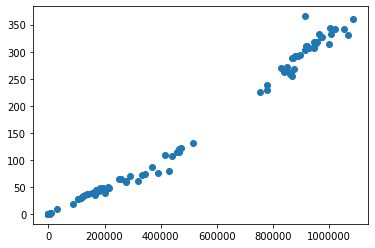

In [15]:
# Confirm that size of files make sense and that I didn't mess up
stats = pd.read_csv('panacealab-data/v6/full_dataset-clean-statistics.tsv', sep = '\t')
number = stats['tweet_id'][1:-1] # change this maybe

filelist = glob.glob('panacealab-data/hydrated/all_english/*gz')
file_sizes = []
for file in filelist:
    file_sizes.append(os.path.getsize(file))
file_sizes = np.divide(file_sizes,1000000)  

plt.scatter(number, file_sizes)

In [94]:
### Make a massive csv file of all tweets, and only take relevant info
## Run on server

filedir = 'panacealab-data/hydrated/all_english/'
filelist = sorted(glob.glob(filedir + '*gz'))

try: # load file if already exists so can easily add more
    tweets = pd.read_csv('big_csv_files/all_tweets.csv')
    print('reading in existing file')
    start_file = tweets['created_at'][len(tweets) - 1].split(' ')[0] + '.jsonl.gz'
    filelist = filelist[filelist.index(filedir + start_file) + 1:]
except:
    tweets = pd.DataFrame(columns = ['created_at','id','full_text','retweet_count','favorite_count','screen_name','location','followers_count'])
    
# pull relevant information, save to df
for file in filelist[0:1]:
    json_name = file.split('english/')[1]
    print('reading tweets from ' + json_name)
    tweets_json = pd.read_json(file, lines = True)
    tweets_relevant = tweets_json[['created_at','id','full_text','retweet_count','favorite_count']]
    tweets_relevant = pd.concat([tweets_relevant, pd.DataFrame(tweets_json['user'].to_list())[['screen_name','location','followers_count']]], axis = 1)
    tweets = tweets.append(tweets_relevant, ignore_index = True)    
tweets = tweets.drop_duplicates(subset = 'full_text', keep = False) # remove duplicates
print('saving all tweets to file')
tweets.to_csv('big_csv_files/all_tweets.csv', index = False)

# Only save tweets where the user has a location listed
print('filtering out users with no location set')
tweets_location = tweets[tweets['location'] != ''].reset_index(drop = True)
tweets_location.to_csv('big_csv_files/location_tweets.csv', index = False)

# Only save tweets where the location is in the USA
# NOTE: For now, just doing this with states so analyses are easier
places_nocase = pd.read_excel('us_places.xlsx',sheet_name = 'no_case')['places'].to_list()
places_case = pd.read_excel('us_places.xlsx',sheet_name = 'case')['places'].to_list()
places = pd.read_excel('us_places.xlsx', sheet_name = 'all')

print('filtering out users outside of the US')
tweets_usa = tweets_location[tweets_location['location'].str.contains('|'.join(places_nocase),case = False)|tweets_location['location'].str.contains('|'.join(places_case))].reset_index(drop = True)

state = tweets_usa['id'].where(tweets_usa['id'] == 1)
for i in range(len(places)):
    if len(places.iloc[i,0]) == 2:
        temp = tweets_usa['location'].where(tweets_usa['location'].str.contains(places.iloc[i,0]))
    else:
        temp = tweets_usa['location'].where(tweets_usa['location'].str.contains(places.iloc[i,0], case = False))
    temp[~temp.isna()] = places.iloc[i,1]
    state = state.combine_first(temp)
tweets_usa['state'] = state
tweets_usa.to_csv('big_csv_files/usa_tweets.csv', index = False)


reading in existing file
reading tweets from 2020-01-27.jsonl.gz
saving all tweets to file
filtering out users with no location set
filtering out users outside of the US


In [12]:
import tqdm

filedir = 'panacealab-data/hydrated/all_english/moved_to_server/'
filelist = sorted(glob.glob(filedir + '*gz'))

tweets = pd.DataFrame(columns = ['created_at','id','full_text','retweet_count','favorite_count','source','entities',
    'screen_name','id','location','followers_count','created_at','statuses_count'])
    
# pull relevant information, save to df
for file in filelist[0:15]:
    json_name = file.split('english/')[1]
    print('reading tweets from ' + json_name)
    tweets_json = pd.read_json(file, lines = True)
    tweets_relevant = tweets_json[['created_at','id','full_text','retweet_count','favorite_count','source','entities']]
    tweets_relevant = pd.concat([tweets_relevant, pd.DataFrame(tweets_json['user'].to_list())[['screen_name','id','location',
        'followers_count','created_at','statuses_count']]], axis = 1)
    tweets = tweets.append(tweets_relevant, ignore_index = True)    
tweets.columns.values[11] = 'user_created_at' # hard coded indexes!
tweets.columns.values[8] = 'user_id'
tweets = tweets.drop_duplicates(subset = 'full_text', keep = False) # remove duplicates
tweets = tweets[tweets['full_text'].str.contains('coronavirus|covid|corona virus', case = False)] #only coronavirus, corona virus or covid
tweets = tweets[~tweets['favorite_count'].isna()].reset_index(drop = True) # get rid of junk

tqdm.tqdm.pandas()
hydration_date = tweets['created_at'].progress_apply(filetime_conv) # this could be sped up I think
tweets['user_created_at'] = pd.to_datetime(tweets['user_created_at'])
tweets['daily_tweet_rate'] = tweets['statuses_count']/(hydration_date.dt.date - tweets['user_created_at'].dt.date).dt.days

tweets_location = tweets[tweets['location'] != ''].reset_index(drop = True)

# Only save tweets where the location is in the USA
places_nocase = pd.read_excel('old/us_places.xlsx',sheet_name = 'no_case')['places'].to_list()
places_case = pd.read_excel('old/us_places.xlsx',sheet_name = 'case')['places'].to_list()
places = pd.read_excel('old/us_places.xlsx', sheet_name = 'all')

print('manually filtering out users outside of the US so geocoding works better')
tweets_usa = tweets_location[tweets_location['location'].str.contains('|'.join(places_nocase),case = False)|tweets_location['location'].str.contains('|'.join(places_case))].reset_index(drop = True)


reading tweets from moved_to_server/2020-01-04.jsonl.gz
reading tweets from moved_to_server/2020-01-06.jsonl.gz
reading tweets from moved_to_server/2020-01-08.jsonl.gz
reading tweets from moved_to_server/2020-01-09.jsonl.gz
reading tweets from moved_to_server/2020-01-10.jsonl.gz
reading tweets from moved_to_server/2020-01-11.jsonl.gz
reading tweets from moved_to_server/2020-01-12.jsonl.gz
reading tweets from moved_to_server/2020-01-13.jsonl.gz
reading tweets from moved_to_server/2020-01-17.jsonl.gz
reading tweets from moved_to_server/2020-01-18.jsonl.gz
reading tweets from moved_to_server/2020-01-19.jsonl.gz
reading tweets from moved_to_server/2020-01-20.jsonl.gz
reading tweets from moved_to_server/2020-01-21.jsonl.gz
reading tweets from moved_to_server/2020-01-22.jsonl.gz


  0%|          | 0/1051 [00:00<?, ?it/s]

reading tweets from moved_to_server/2020-01-23.jsonl.gz


100%|██████████| 1051/1051 [00:00<00:00, 2171.07it/s]


manually filtering out users outside of the US so geocoding works better


In [122]:
def url_filter(url):
    if not url:
        return 1
    elif url[0]['display_url'].startswith('twitter.com'):
        return 1
    else:
        return 0

In [9]:
top_users = tweets['user_id'].value_counts()[0:20].index.to_list()
tweets_top_users = tweets[tweets['user_id'].isin(top_users)].reset_index(drop = True)

top_users_df = tweets_top_users[['screen_name','user_id','location','followers_count','statuses_count']]
top_users_df = top_users_df.drop_duplicates(subset = 'screen_name').reset_index(drop = True)
users_list_got = top_users_df[['screen_name']]
users_list_got.to_csv('big_csv_files/users_list_got.csv',index = False, header = False)

args = ['GetOldTweets3','--usernames-from-file', 'big_csv_files/users_list_got.csv','--maxtweets','1000','--output','big_csv_files/got_tweets.csv']
t = subprocess.Popen(args)
t.wait()

got_tweets = pd.read_csv('big_csv_files/got_tweets.csv')
got_tweets = got_tweets.drop(columns = ['permalink','geo','mentions','hashtags','to'])
got_tweets = got_tweets.rename(columns = {'username':'screen_name'})

In [9]:
def filetime_conv(created_at):
    outputdir = 'panacealab-data/hydrated/all_english/moved_to_server/'
    file_for_conv = outputdir + str(created_at).split(' ')[0] + '.jsonl.gz'
    timect = pd.to_datetime(time.ctime(os.path.getctime(file_for_conv)))
    return timect

In [ ]:
# Run through jsons, extract tweets only if they have specific key words?

In [ ]:
# Should I try to employ a model that only keeps tweets that have any sort of sentiment?
# For now, no, but eventually, hopefully. Will make results stronger most likely

In [ ]:
# preprocessing. Remove URLs, symbols, stop words, etc.

tweets = pd.read_csv('big_csv_files/usa_tweets.csv')

# remove duplicate tweets
tweets = tweets.drop_duplicates(subset = 'full_text', keep = False)

# get rid of links and emojis?? For now, no


In [19]:
#### geocoding!
import geopandas
import geopy

locator = geopy.geocoders.Nominatim(user_agent='myGeocoder')
location = locator.geocode('Boston, MA')

In [38]:
import requests
import urllib

#Sample latitude and longitudes
lat = g[2].latlng[0]
lon = g[2].latlng[1]

#Encode parameters 
params = urllib.parse.urlencode({'latitude': lat, 'longitude':lon, 'format':'json'})
#Contruct request URL
url = 'https://geo.fcc.gov/api/census/block/find?' + params

#Get response from API
response = requests.get(url)

#Parse json in response
data = response.json()

#Print FIPS code
print(data['County']['FIPS'])

AttributeError: 'list' object has no attribute 'latlng'

In [2]:
import tqdm
import geocoder

In [36]:
# feed in list of coordinates
def coord_to_fips(x):
    params = urllib.parse.urlencode({'latitude': x[0], 'longitude':x[1], 'format':'json'})
    url = 'https://geo.fcc.gov/api/census/block/find?' + params
    response = requests.get(url)
    data = response.json()
    return data['County']['FIPS']

In [40]:
from progressbar import ProgressBar
pbar = ProgressBar()
g_fips = [coord_to_fips(coords) for coords in pbar(g)]


TypeError: 'NoneType' object is not subscriptable

In [86]:
from progressbar import ProgressBar
pbar = ProgressBar()
#g = tweets_usa['location'].progress_apply(geocoder.arcgis)
g = [geocoder.osm(location, url = 'http://128.59.231.131/nominatim/search.php') for location in pbar(tweets_usa['location'])]

ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Austin+Texas&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Tucson%2C+AZ&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=East+Brunswick%2C+NJ&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=San+Marcos%2C+TX&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 

ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Utah%2C+USA&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Spokane+WA&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Stoneville%2C+NC&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=California&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http

ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Dallas%2C+TX&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Richmond%2C+TX&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Cornelius%2C+OR&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Maine%2C+USA&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 fro

ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Maryland%2C+USA&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=San+Francisco%2C+California&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Virginia%2C+USA&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=Miami&format=jsonv2&addressdetails=1&limit=1
ERROR:geocoder.base:Status cod

In [94]:
geocoder.osm("New York City", url = 'http://128.59.231.131/nominatim/search.php')

ERROR:geocoder.base:Status code 500 from http://128.59.231.131/nominatim/search.php: ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=New+York+City&format=jsonv2&addressdetails=1&limit=1


<[ERROR - 500 Server Error: Internal Server Error for url: http://128.59.231.131/nominatim/search.php?q=New+York+City&format=jsonv2&addressdetails=1&limit=1] Osm - Geocode [empty]>

In [51]:
from geopy.geocoders import OpenMapQuest
geolocator = OpenMapQuest(api_key = 'p047o1tyzswK5IDBKurrrcbB712eGS1f', timeout = 10)
location = geolocator.geocode("New York City")
print(location)

NYC, New York, United States of America


In [32]:
#tqdm.tqdm.pandas()
#g = tweets_usa['location'].progress_apply(geolocator.geocode)
g = geocoder.komoot(tweets_usa['location'].to_list())

ValueError: Invalid method

In [28]:
import geocoder
import tqdm
from geopy.geocoders import ArcGIS
#geolocator = OpenMapQuest(api_key = 'p047o1tyzswK5IDBKurrrcbB712eGS1f', timeout = 10)
#geolocator = ArcGIS(timeout = 3)
pbar = tqdm.tqdm(total=len(tweets_usa['location']))

import multiprocessing

addresses = tweets_usa['location']
addresses = addresses[0:20]

def geocode_worker(address):
#    print(address)
    pbar.update(1)
    return geocoder.komoot(address).latlng
#    return geolocator.geocode(address)


def main_process():
    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count() - 1)
    return pool.map(geocode_worker, addresses, chunksize = 10)

if __name__ == '__main__':
    g = main_process()












  0%|          | 0/244 [00:00<?, ?it/s]








  1%|          | 2/244 [00:00<00:39,  6.10it/s]








  1%|          | 2/244 [00:00<00:56,  4.25it/s]








  1%|          | 3/244 [00:00<00:47,  5.03it/s]








  1%|          | 3/244 [00:00<01:00,  4.01it/s]








  2%|▏         | 4/244 [00:00<00:53,  4.45it/s]








  2%|▏         | 4/244 [00:01<01:02,  3.83it/s]








  2%|▏         | 5/244 [00:01<00:58,  4.10it/s]








  2%|▏         | 5/244 [00:01<01:03,  3.75it/s]








  2%|▏         | 6/244 [00:01<01:01,  3.88it/s]








  2%|▏         | 6/244 [00:01<01:06,  3.60it/s]








  3%|▎         | 7/244 [00:01<01:02,  3.77it/s]








  3%|▎         | 7/244 [00:01<01:05,  3.64it/s]








  3%|▎         | 8/244 [00:02<01:04,  3.68it/s]








  3%|▎         | 8/244 [00:02<01:06,  3.57it/s]








  4%|▎         | 9/244 [00:02<01:04,  3.64it/s]








  4%|▎         | 9/244 [00:02<01:06,  3.55it/s]








  4%|▍         | 10/244 [00:02<01:04,  3.61it/s

In [25]:
g

[[30.284151, -97.73195598080218],
 [32.3163966, -111.0448428],
 [40.4561987, -74.4004402],
 [33.2091166, -96.7306516],
 [42.3602534, -71.0582912],
 [40.72925325, -73.99625393609625],
 [36.1445, -113.110927],
 [38.8948932, -77.0365529],
 [36.101795, -114.9370274],
 [31.8160381, -99.5120986],
 [40.712742950000006, -74.00595024412516],
 [39.174625, -84.2958988],
 [30.4079122, -98.1056265],
 [46.4656916, -119.3255748],
 [38.4404925, -122.7141049],
 [43.06922635, -76.17248945485272],
 [33.7910822, -84.37322951720375],
 None,
 [36.7014631, -118.7559974],
 [38.9409821, -94.6054383]]

In [17]:
import geocoder
geocoder.komoot('New York City, NY').state


'New York'

In [11]:
import multiprocessing
import geocoder

addresses = tweets_usa['location']

def worker(address):
    return geocoder.arcgis(address)

if __name__ == '__main__':
    jobs = []
    for i in range(len(addresses)):
        p = multiprocessing.Process(target=worker, args=(i,))
        jobs.append(p)
        p.start()

OSError: [Errno 24] Too many open files

In [12]:
jobs

[<Process(Process-386, stopped[SIGSEGV])>,
 <Process(Process-387, stopped[SIGSEGV])>,
 <Process(Process-388, stopped[SIGSEGV])>,
 <Process(Process-389, stopped[SIGSEGV])>,
 <Process(Process-390, stopped[SIGSEGV])>,
 <Process(Process-391, stopped[SIGSEGV])>,
 <Process(Process-392, stopped[SIGSEGV])>,
 <Process(Process-393, stopped[SIGSEGV])>,
 <Process(Process-394, stopped[SIGSEGV])>,
 <Process(Process-395, stopped[SIGSEGV])>,
 <Process(Process-396, stopped[SIGSEGV])>,
 <Process(Process-397, stopped[SIGSEGV])>,
 <Process(Process-398, stopped[SIGSEGV])>,
 <Process(Process-399, stopped[SIGSEGV])>,
 <Process(Process-400, stopped[SIGSEGV])>,
 <Process(Process-401, stopped[SIGSEGV])>,
 <Process(Process-402, stopped[SIGSEGV])>,
 <Process(Process-403, stopped[SIGSEGV])>,
 <Process(Process-404, stopped[SIGSEGV])>,
 <Process(Process-405, stopped[SIGSEGV])>,
 <Process(Process-406, stopped[SIGSEGV])>,
 <Process(Process-407, stopped[SIGSEGV])>,
 <Process(Process-408, stopped[SIGSEGV])>,
 <Process(P

In [83]:
addresses

0              Austin Texas
1                Tucson, AZ
2        East Brunswick, NJ
3            San Marcos, TX
4                Boston, MA
               ...         
156    Oakbrook Terrace, IL
157               Cleveland
158         Intercourse, PA
159        Washington, D.C.
160             Atlanta, GA
Name: location, Length: 161, dtype: object

In [62]:
### Interrupted time series, take top users, collect all of their tweets, look at change in emotion/sentiment/topic
# Prep

filedir = 'panacealab-data/hydrated/all_english/moved_to_server/'
filelist = sorted(glob.glob(filedir + '*gz'))


tweets = pd.DataFrame(columns = ['created_at','id','full_text','retweet_count','favorite_count',
    'screen_name','id','location','followers_count','created_at','statuses_count'])
    
# pull relevant information, save to df
for file in filelist[0:15]:
    json_name = file.split('server/')[1]
    print('reading tweets from ' + json_name)
    tweets_json = pd.read_json(file, lines = True)
    tweets_relevant = tweets_json[['created_at','id','full_text','retweet_count','favorite_count']]
    tweets_relevant = pd.concat([tweets_relevant, pd.DataFrame(tweets_json['user'].to_list())[['screen_name','id','location',
        'followers_count','created_at','statuses_count']]], axis = 1)
    tweets = tweets.append(tweets_relevant, ignore_index = True)    
tweets.columns.values[9] = 'user_created_at'
tweets.columns.values[6] = 'user_id'
tweets = tweets.drop_duplicates(subset = 'full_text', keep = False) # remove duplicates
tweets = tweets[tweets['full_text'].str.contains('coronavirus|covid|corona virus', case = False)] #only coronavirus, corona virus or covid
tweets = tweets[~tweets['favorite_count'].isna()].reset_index(drop = True) # get rid of junk


hydration_date = tweets['created_at'].apply(filetime_conv)
tweets['user_created_at'] = pd.to_datetime(tweets['user_created_at'])
tweets['daily_tweet_rate'] = tweets['statuses_count']/(hydration_date.dt.date - tweets['user_created_at'].dt.date).dt.days
tweets = tweets[tweets['daily_tweet_rate'] < 100]. reset_index(drop = True)


tweets_unique_users = tweets.drop_duplicates(subset = 'screen_name').reset_index(drop = True)
selected_users = tweets_unique_users['screen_name'].sample(n = 30, random_state = 0).to_list()
tweets_selected_users = tweets_unique_users[tweets_unique_users['screen_name'].isin(selected_users)].reset_index(drop = True)

selected_users_df = tweets_selected_users[['screen_name','user_id','location','followers_count','statuses_count','daily_tweet_rate']]
users_list_got = selected_users_df[['screen_name']]
users_list_got.to_csv('big_csv_files/users_list_got.csv',index = False, header = False)

args = ['GetOldTweets3','--usernames-from-file', 'big_csv_files/users_list_got.csv','--maxtweets','1000','--output','big_csv_files/got_tweets.csv']
t = subprocess.Popen(args)
t.wait()

got_tweets = pd.read_csv('big_csv_files/got_tweets.csv')
got_tweets = got_tweets.drop(columns = ['permalink','geo','mentions','hashtags','to'])
got_tweets = got_tweets.rename(columns = {'username':'screen_name'})
selected_users_full = got_tweets.merge(selected_users_df, on = 'screen_name')

reading tweets from 2020-01-04.jsonl.gz
reading tweets from 2020-01-06.jsonl.gz
reading tweets from 2020-01-08.jsonl.gz
reading tweets from 2020-01-09.jsonl.gz
reading tweets from 2020-01-10.jsonl.gz
reading tweets from 2020-01-11.jsonl.gz
reading tweets from 2020-01-12.jsonl.gz
reading tweets from 2020-01-13.jsonl.gz
reading tweets from 2020-01-17.jsonl.gz
reading tweets from 2020-01-18.jsonl.gz
reading tweets from 2020-01-19.jsonl.gz
reading tweets from 2020-01-20.jsonl.gz
reading tweets from 2020-01-21.jsonl.gz
reading tweets from 2020-01-22.jsonl.gz
reading tweets from 2020-01-23.jsonl.gz
reading tweets from 2020-01-24.jsonl.gz


In [ ]:
## Actually do it